In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from datetime import datetime
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

In [2]:
from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()
start_all = datetime.now()

In [3]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(y_test, y_pred):
   accuracy = np.around(metrics.accuracy_score(y_test, y_pred),3)
   precision = np.around(metrics.precision_score(y_test, y_pred, average='macro'),3)
   recall = np.around(metrics.recall_score(y_test, y_pred, average='macro'),3)
   f1_score = np.around(metrics.f1_score(y_test, y_pred, average='macro'),3)
   print(classification_report(y_test, y_pred))  
   print('accuracy: %s' % accuracy)
   print('precision: %s' % precision)
   print('recall: %s' % recall)
   print('f1_score: %s' % f1_score)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score}

def vader_sentiment(doc):
   analyzer= SentimentIntensityAnalyzer()
   score = analyzer.polarity_scores(doc)['compound']
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def textblob_sentiment(doc):
   from textblob import TextBlob
   score = TextBlob(doc).sentiment.polarity
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def plot_confusion_matrix(y_test, y_pred):
   from sklearn.preprocessing import MinMaxScaler
   from sklearn.metrics import classification_report, confusion_matrix
   
   labels = np.unique(y_test)
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print(cm_df)
   cmap = sns.color_palette("OrRd", 1000)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def vizualize_classification(y_test, y_pred):
   from sklearn.metrics import classification_report, confusion_matrix
   labels = np.unique(y_test)
   cmap = sns.color_palette("OrRd", 1000)
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
   fig.suptitle('Vizualizing classifier')
   
   ax = sns.countplot(x=y_pred, hue=y_test, order=labels, ax=ax1)
   
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print('Confusion Matrix: \n', cm_df)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g', ax=ax2)
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   evaluate_model(y_test, y_pred)
      
def textblob_NBClassifier(doc):
   blob = TextBlob(doc, classifier=cl)
   return blob.classify()

def multilabel_evaluation(y_pred, y_test, measurement=None):
   '''
   Micro accuracy, recall, precision, f1_score evaluation
   '''
   from sklearn.metrics import hamming_loss, multilabel_confusion_matrix
   multilabel_cm = multilabel_confusion_matrix(y_pred, y_test)
   if measurement=='macro':
      tn = np.mean(multilabel_cm[:, 0, 0])
      tp = np.mean(multilabel_cm[:, 1, 1])
      fp = np.mean(multilabel_cm[:, 0, 1])
      fn = np.mean(multilabel_cm[:, 1, 0])
      accuracy = np.around(((tp + tn)/(tn + tp + fn +fp)), 3)
      precision = np.around((tp/(tp + fp)), 3)
      recall = np.around((tp/(tp + fn)), 3)
      f1_score = np.around(2* recall*precision/(recall + precision), 3)
   else:
      tn = multilabel_cm[:, 0, 0]
      tp = multilabel_cm[:, 1, 1]
      fp = multilabel_cm[:, 0, 1]
      fn = multilabel_cm[:, 1, 0]
      ac, p, r = [], [], []
      for i in range(len(tp)):
         ac.append((tp[i] + tn[i])/(tn[i] + tp[i] + fn[i] + fp[i]))
         p.append(0 if tp[i]==0 and fp[i]==0 else tp[i]/(tp[i] + fp[i]))
         r.append(0 if tp[i]==0 and fn[i]==0 else tp[i]/(tp[i] + fn[i]))
     
      accuracy = np.around(np.mean(ac), 3)
      precision = np.around(np.mean(p), 3)
      recall = np.around(np.mean(r), 3)   
      f1_score = np.around(2* recall*precision/(recall + precision), 3)
   hamming = np.around(hamming_loss(y_test, y_pred), 3)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score,
           'hamming_loss':hamming}

def multilabel_visualization(values, labels):
   df = pd.DataFrame(data={label:values[:,i] for i, label in enumerate(feelings)})
   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,7))
   fig.suptitle('Class analysis')
   # Label distribution
   df[labels].sum().sort_values(ascending=False).plot(kind='bar', title='Label distribution', ax=ax1)
   # Multiple labels
   sns.countplot(x=df[labels].sum(axis=1), ax=ax2).set_title('Tweets with multiple labels')
   # Word cloud
   # Create target column 'labels'
   df['labels'] = [np.asarray(labels)[i] for i in df[labels].astype('bool').values]
   # Concatenate all labesl together
   words = np.hstack(df['labels'].values)
   # Vizualize label wordcloud
   wc_dict = dict(Counter(words))
   wordcloud = WordCloud(colormap='Blues', 
                         max_font_size=100, 
                         width=300, 
                         height=200).generate_from_frequencies(wc_dict)
   plt.title('Label wordcloud')
   # plt.figure( figsize=(20,10) )

   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()
   # correlation visualization
   emotion_corr_heatmap(values, labels=labels)
   
def emotion_corr_heatmap(values, labels=[]):
   if type(values)==pd.DataFrame:
      data = values.corr()
   else:
      data = pd.DataFrame(data=values, columns=labels).corr()
   
   # Generate a mask for the upper triangle
   mask = np.triu(np.ones_like(data, dtype=np.bool))
   cmap = sns.diverging_palette(220, 10, as_cmap=True)
   # Draw the heatmap with the mask and correct aspect ratio
   max_val = np.sort(data, axis=None)[::-1][data.shape[1]]
   ax = sns.heatmap(data, 
               mask=mask, 
               cmap=cmap, 
               center=0,
               square=True, 
               linewidths=.5, 
               cbar_kws={"shrink": .5})
   plt.title('Primitive emotion correlation')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def draw_wordcloud(corpus):
   from wordcloud import WordCloud, STOPWORDS
   from collections import Counter
   from nltk.util import ngrams 
   from nltk.corpus import stopwords
   
   if type(corpus)!=str:
      corpus = ' '.join(corpus).split(' ')
   stop_words = set(list(STOPWORDS) + stopwords.words('english'))
   corpus = [w for w in corpus if w.lower() not in stop_words]
   bigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 2)).most_common()}
   trigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 3)).most_common()}   
   corpus_dict = dict(Counter(corpus).most_common())
   word_count = {**corpus_dict, **bigrams_count, **trigrams_count}
   # draw a Word Cloud with word frequencies
   wordcloud = WordCloud(max_words=50,
                         max_font_size=75,
                         colormap='Pastel2_r',
                        ).generate_from_frequencies(word_count)
   plt.figure(figsize=(10,8))
   plt.title('Wordcloud of unigrams, bigrams, trigrams')
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()
      

In [4]:
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
print(emo_train_df.shape)
emo_train_df.head()

(6838, 13)


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Data exploration

Class distribution

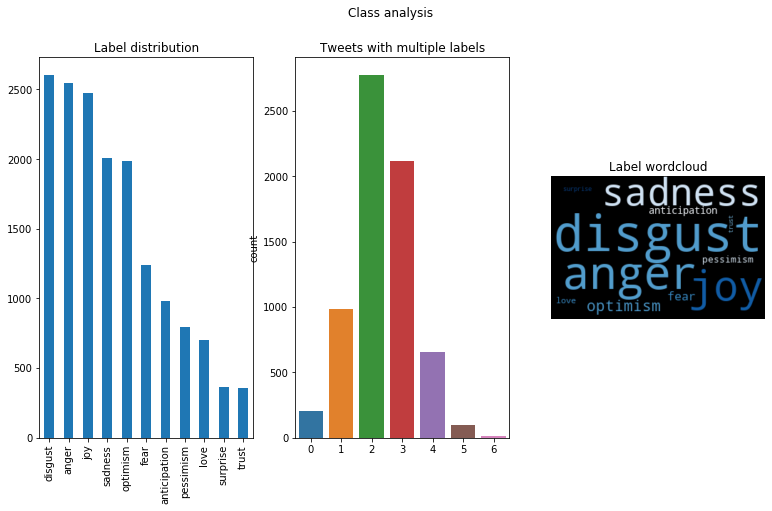

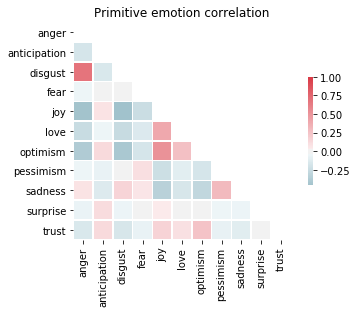

In [5]:
feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
multilabel_visualization(emo_train_df[feelings].values, feelings)

Preprocessing:
* Tokenization
* Stopword removal
* Special character handling
* Emoji parsing
* Data cleaning

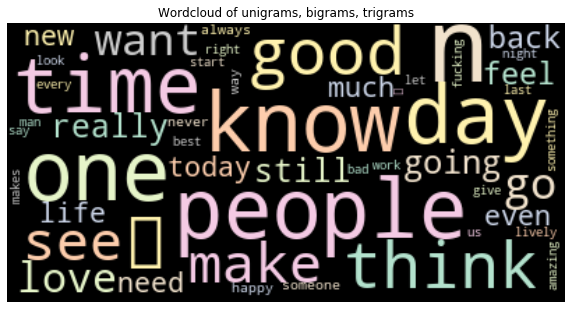

In [6]:
emo_train_df['tokenized_features'] = emo_train_df['Tweet'].apply(tweet_processor.tweet_pipeline)

corpus = emo_train_df['tokenized_features'].apply(lambda x: ' '.join(x))
draw_wordcloud(corpus)

## Feature selection

In [7]:
# Tweet preprocessing
emo_train_df['tokenized_features'] = emo_train_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = emo_train_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# LDA features
X_lda = tweet_processor.lda_features(X, len(feelings))


 Dataset split

In [14]:
# Combine features
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))
y = emo_train_df[feelings].values
x_train_id, x_test_id, y_train, y_test = train_test_split(range(X_combined.shape[0]), y, test_size=0.2, random_state=0)
x_train, x_test = X_combined[x_train_id], X_combined[x_test_id]
x_train.shape, y_train.shape, x_test.shape

((5470, 5329), (5470, 11), (1368, 5329))

## Classification

One-vs-rest classification

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline


print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
print(multilabel_evaluation(y_pred, y_test))
# print(best_clf.get_params())
print('Finished classification in : ', datetime.now()-start) 



Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.0s finished


Finished training in :  0:00:12.605913
{'accuracy': 0.843, 'precision': 0.365, 'recall': 0.577, 'f1_score': 0.447, 'hamming_loss': 0.157}
Finished classification in :  0:00:00.002919


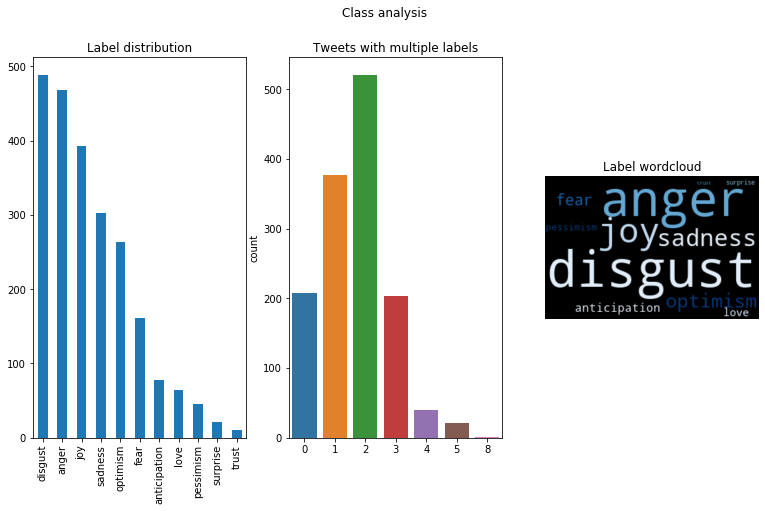

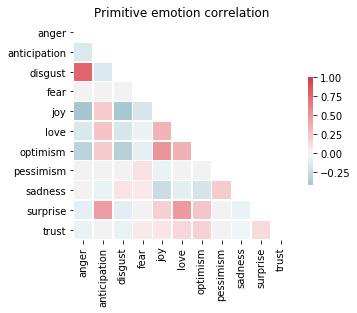

In [10]:
multilabel_visualization(y_pred, feelings)

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting OneVsRestClassifier MultinomialNB classifier...")
print("")
start = datetime.now()

parameters = [{
            'estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(OneVsRestClassifier(MultinomialNB(class_prior=None)), 
                              parameters, 
                              cv=2,
                              verbose=1,
                             n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 
start = datetime.now()
y_pred = best_clf.predict(x_test)
print(multilabel_evaluation(y_pred, y_test))
# print(best_clf.get_params())
print('Finished classification in : ', datetime.now()-start) 



Starting OneVsRestClassifier MultinomialNB classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.9s finished


Finished training in :  0:00:03.386755
{'accuracy': 0.841, 'precision': 0.235, 'recall': 0.69, 'f1_score': 0.351, 'hamming_loss': 0.159}
Finished classification in :  0:00:00.066956


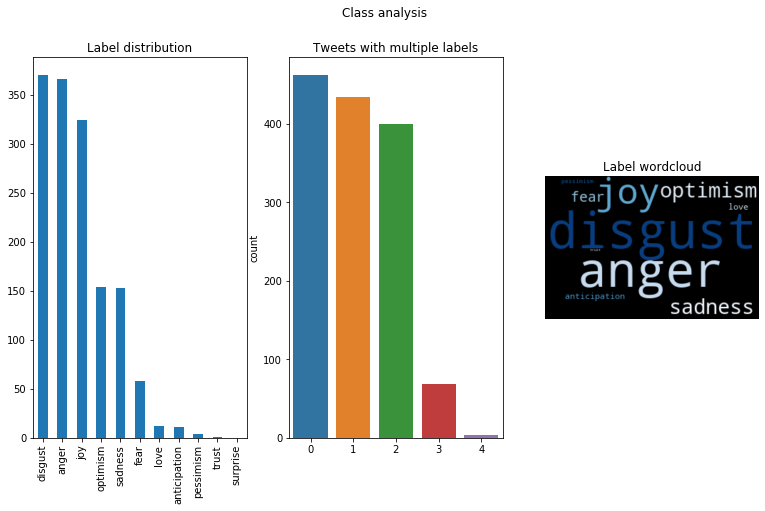

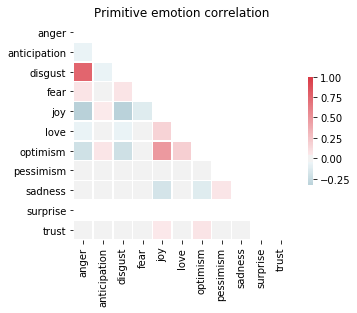

In [17]:
multilabel_visualization(y_pred, feelings)

In [13]:
print('Finished training in : ', datetime.now()-start_all)

Finished training in :  0:00:34.530155


# TODO

1. New evaluation metric: distance of emotion correlation between train and test set
2. ROC evaluation

~~3. Check TextBlob NB classifier~~

4. Check other features from TweetProcessor module

~~5. Check LDA features~~

~~6. \[2,3\]grams wordcloud~~

---
7. Deal with class impalance
8. Other multiclass methods apart from One-vs-rest
9. Deal with uncertainty